In [2]:
import numpy as np
import dataIO, GPy
from sklearn import cross_validation, linear_model, preprocessing
reload(dataIO)

def learn_offset(points, targets):
    regr = linear_model.LinearRegression()
    regr.fit(points, targets)
    
    return regr
                
locations, bod, targets_x, targets_y, y, touch_centers = dataIO.process_twohand(17)

locations = np.array(locations)
bod = np.array(bod)
targets_x = np.array(targets_x)
targets_y = np.array(targets_y)
y = np.array(y)
touch_centers = np.array(touch_centers)

print("MSE on x before regression: %.2f"  % np.mean(targets_x ** 2))
print("MSE on y before regression: %.2f"  % np.mean(targets_y ** 2))
within_before = dataIO.circle_button_error(locations, touch_centers)
locations = np.concatenate((locations, locations**2),1)

foldno = 1
se_x = []
se_y = []
within_after = []
kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True)

for train_index, test_index in kf:
    print
    print ("##### Fold %d #####"%foldno)
    print
    
    points_train, points_test = locations[train_index], locations[test_index]
    bod_train, bod_test = bod[train_index], bod[test_index]
    t_x_train, t_x_test = targets_x[train_index], targets_x[test_index]
    t_y_train, t_y_test = targets_y[train_index], targets_y[test_index]
    y_train, y_test = y[train_index], y[test_index]
    centers_train, centers_test = touch_centers[train_index], touch_centers[test_index]
    
    scaler = preprocessing.StandardScaler().fit(bod_train)  
    bod_scaled = scaler.transform(bod_train)    
    y_train = y_train.reshape(y_train.size, 1)

    gammas = np.array([10, 1, 0.1 ,1e-2, 1e-3])
    lengthscales = np.sqrt(1.0/(2*gammas))
    
    l = dataIO.grid_search(bod_scaled, y_train, lengthscales)
    print ("Best lengthscale: %.2f" %l)
    
    kernel= GPy.kern.RBF(24, variance=1., lengthscale=l)  
    m = GPy.models.GPClassification(X = bod_scaled, Y = y_train, kernel=kernel)
    
    regr_x = []
    regr_y = []
    
    for i in range(0,2):
        index = np.where(y_train==i)[0]
        regr_x.append(learn_offset(points_train[index], t_x_train[index]))
        regr_y.append(learn_offset(points_train[index], t_y_train[index]))
        
    new_points = np.zeros((points_test.shape[0],2))
    for i in range(len(points_test)):
        
        point = points_test[i]
        bod_data = scaler.transform(bod_test[i])
        bod_data = bod_data.reshape(1, 24)
        prob = m.predict(bod_data)[0][0][0]
            
        pred_x = (1-prob)*regr_x[0].predict(point) + prob*regr_x[1].predict(point)
        pred_y = (1-prob)*regr_y[0].predict(point) + prob*regr_y[1].predict(point)
        
        new_points[i][0] = point[0]+pred_x
        new_points[i][1] = point[1]+pred_y
     
    within_after.append(dataIO.circle_button_error(new_points, centers_test))
    new_points = np.array(new_points).T
    centers_test = centers_test.T
    
    se_x.append((new_points[0]-centers_test[0])**2)
    se_y.append((new_points[1]-centers_test[1])**2)
    foldno +=1

se_x = np.array([item for sublist in se_x for item in sublist])
se_y = np.array([item for sublist in se_y for item in sublist])

print 
print("Mean MSE on x: %.2f" % np.mean(se_x))
print("Mean MSE on y: %.2f" % np.mean(se_y))      
within_after = np.mean(np.array(within_after), 0)
            

MSE on x before regression: 317.33
MSE on y before regression: 244.25

##### Fold 1 #####

Best lengthscale: 0.71

##### Fold 2 #####

Best lengthscale: 2.24

##### Fold 3 #####

Best lengthscale: 2.24

##### Fold 4 #####

Best lengthscale: 2.24

##### Fold 5 #####

Best lengthscale: 2.24

##### Fold 6 #####

Best lengthscale: 2.24

##### Fold 7 #####

Best lengthscale: 2.24

##### Fold 8 #####

Best lengthscale: 0.71

##### Fold 9 #####

Best lengthscale: 2.24

##### Fold 10 #####

Best lengthscale: 2.24

Mean MSE on x: 112.37
Mean MSE on y: 217.26


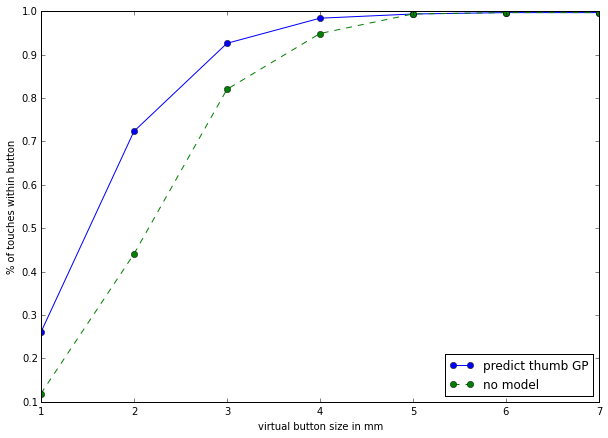

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 7))

plt.errorbar(range(1,8), within_after, marker="o", label="predict thumb GP")
plt.errorbar(range(1,8), within_before, linestyle="--", marker="o", label="no model")

plt.legend(loc='lower right')
plt.xlabel('virtual button size in mm')
plt.ylabel('% of touches within button')
plt.show()